# <span style="color:turquoise">Text classification with pytorch</span>


An example of using natural language processing for sentiment analysis. <br> Building a binary classifier of movie reviews that will predict if a review is positive or negative.




__Dataset:__ IMDB movie reviews from Kaggle<br>
__Model:__ LSTM


In [1]:
import csv
import random
import numpy as np
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## <span style="color:teal">Read the data and split it into training, cross-validation, and test sets</span>

In [2]:
class Reviews():
    
    def __init__(self):
        self.train = {}
        self.val = {}
        self.test = {}
        self.LABELS = {"positive":1, "negative": 0}
        self.COUNT = {"positive": 0, "negative": 0}
    
    
    def read_data(self):
        
        dataset = []
        
        with open ("IMDB_Dataset.csv", newline='') as f:
            datareader = csv.reader(f, delimiter=',')
            next(datareader, None)

            for row in datareader:
                dataset.append([row[0], self.LABELS[row[1]]])
                self.COUNT[row[1]] += 1
            
            random.shuffle(dataset)
                
        return dataset




    def split_dataset(self,
                      dataset,
                      split=[int(50000*0.6), int(50000*0.2), int(50000*0.2)]):
        
        train, val, test = torch.utils.data.random_split(dataset,
                                               split,
                                               generator=torch.Generator().manual_seed(43))
          
            
        return train, val, test

In [3]:
rev = Reviews()
data = rev.read_data()
pos_count = rev.COUNT["positive"]
neg_count = rev.COUNT["negative"]


In [4]:
print(data[10])

["For one thing, he produced this movie. It has the feel of later movies with international casts that are dubbed. The opening credits tell us it was filmed in Vienna. This isn't terrible but it's pretty heavy going.", 0]


In [5]:
train, val, test = rev.split_dataset(data)
print(train[10])

['Ronald Colman won a Best Actor Oscar for showy performance as a popular stage thespian who completely loses himself in his roles, particularly as Shakespeare\'s Othello. Critically-lauded George Cukor film has a marvelous pedigree, having been written by the estimable team of Ruth Gordon and Garson Kanin. Unfortunately, the witty banter comes off as self-conscious here, and the backstage business is overripe. Miklós Rózsa also won an Oscar for his score, and Shelley Winters has a few fine moments a tough waitress (when theatrical Colman breathlessly addresses her, she asks him, "What are ya? Some kind of nut?"). Otherwise, this scenario is awfully obvious, surprisingly draggy, and not very funny. *1/2 from ****', 0]


In [6]:
print(len(train), len(val), len(test))

30000 10000 10000


In [7]:
def split_x_and_y(data):
    x = []
    y = []
    for review, label in data:
        x.append(review)
        y.append(label)
    return x, np.array(y)

In [8]:
train_x_raw, train_y = split_x_and_y(train)
val_x_raw, val_y = split_x_and_y(val)
test_x_raw, test_y = split_x_and_y(test)


print(len(train_x_raw), len(train_y))
#print(train_x_raw[50], train_y[50])

# Check if datasets are balanced - how many positive reviews in each
print(np.count_nonzero(train_y), np.count_nonzero(val_y), np.count_nonzero(test_y))

30000 30000
15031 4967 5002


## <span style="color:teal">Preprocess text</span>

In [9]:
def preprocess(review,
               remove_stopwords=False, 
               remove_html=True, 
               remove_punct=False, 
               lowercase=False, 
               lemmatize=False,
               maxlen=None):
    
    review = re.sub(r"\'", "'", review)
    review = re.sub(r"\x96", "-", review)
    
    if remove_html:
        review = re.sub(r'<.*>', ' ', review)
    
    review = word_tokenize(review)
        
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        review = [w for w in review if w not in stop_words]
        
    if remove_punct:
        contractions = ["'ll", "'s", "n't", "'d", "'m", "'ve", "'re"]
        review = [w for w in review if w.isalnum() or w in contractions]
    
    if lowercase:
        review = [w.lower() for w in review]
        
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        review = [lemmatizer.lemmatize(w) for w in review]
    
    
    return review[:maxlen]
    


In [10]:
train_words = [preprocess(review, 
                      lowercase=True, 
                      remove_punct=True,
                      remove_stopwords=True
                     ) 
           for review in train_x_raw]

val_words = [preprocess(review, 
                    lowercase=True, 
                    remove_punct=True,
                    remove_stopwords=True
                   ) 
         for review in val_x_raw]

In [11]:
print(train_words[9592], '\n', val_words[3029])
print(len(train_words[9592]), '\n', len(val_words[3029]))

['george', 'mildred', 'the', 'movie', 'lacks', 'talents', 'tv', 'writer', 'john', 'mortimer', 'brings', 'close', 'quarter', 'cut', 'thrust', 'george', "'s", 'class', 'war', 'fourmiles', 'alive', 'for', 'fans', '70', "'s", 'british', 'comedy', 'want', 'revisit', 'old', 'tv', 'companion', 'youth', 'film', 'add', 'nothing', 'experience', 'stick', 'first', 'four', 'tv', 'series', 'dvd'] 
 ['watching', 'cbs', "'s", 'surrender', 'dorothy', 'i', 'kept', 'wondering', 'diane', 'keaton', 'would', 'want', "'s", 'television', 'movie', 'dearth', 'enticing', 'roles', 'slightly', 'older', 'actresses', "n't", 'wonder', 'academy', 'award', 'winning', 'performers', 'keaton', 'turn', 'tv', 'offers', 'opportunities', 'keaton', 'shine', 'a', 'single', 'mother', 'grieving', 'sudden', 'death', 'daughter', 'imposes', 'upon', 'gradually', 'becomes', 'friends', 'group', 'young', 'people', 'daughter', 'close', 'time', 'accident', 'adapted', 'novel', 'teleplay', 'gives', 'us', 'group', 'characters', 'one', 'would

In [12]:
print(len(train_words))

30000


## <span style="color:teal">Convert text to indices and add paddings</span>

In [13]:
def make_vocabulary(preprocessed_data, 
                    vocab_size=15000,
                    pad_token='<PAD>',
                    unk_token='<UNK>'):
    
    # Create a vocabulary list of a given size
    freqs = {}
    for review in preprocessed_data:
        for word in review:
            freqs[word] = freqs.get(word, 0) + 1
            
    freqs_list = Counter(freqs).most_common(vocab_size)
    
    assert len(freqs_list) == vocab_size
    
    # Create word-index mappings
    vocab_list = [pair[0] for pair in freqs_list]
    word2ind = {word : i+2 for i, word in enumerate(vocab_list)}
    
    # Prepend the pad token
    word2ind[pad_token] = 0
    
    # Prepend the 'unknown' token
    word2ind[unk_token] = 1

    
    return word2ind
  
    

In [14]:
word2ind = make_vocabulary(train_words, vocab_size=10000)

print(len(word2ind))
print(word2ind['i'], word2ind['awful'])

10002
2 246


In [15]:
print(word2ind['not'])

157


In [16]:
del train_x_raw, val_x_raw

In [17]:
print(np.max([len(x) for x in train_words]))
print(np.mean([len(x) for x in train_words]))

print(np.max([len(x) for x in val_words]))
print(np.mean([len(x) for x in val_words]))

612
78.34616666666666
582
77.7976


In [18]:
def make_padded_inputs(preprocessed_data, 
                       vocab, 
                       padded_length=64,
                       pad_token='<PAD>',
                       unk_token='<UNK>'):
    
    num_lines = len(preprocessed_data)
    pad = vocab[pad_token]
    
    inputs = np.full((num_lines, padded_length), pad)
    
    for i, review in enumerate(preprocessed_data):
        if len(review) <= padded_length:
            start_position = padded_length - len(review)
        else:
            start_position = 0
        for j, word in enumerate(review[:padded_length]):
            inputs[i, (start_position + j)] = vocab.get(word, vocab[unk_token])       
    return inputs
            

In [19]:
train_x = make_padded_inputs(train_words, word2ind)
val_x = make_padded_inputs(val_words, word2ind)


print(f"""Training example at indices 5 and 6:\n{train_words[5:7]}\n
    Converted to indices:\n{train_x[5:7, :]}\n""")

print(len(train_words[5]), np.count_nonzero(train_x[5]))

assert (len(train_words[5]) == np.count_nonzero(train_x[5])) or (64 == np.count_nonzero(train_x[5]))

Training example at indices 5 and 6:
[['one', 'favorite', 'movies', 'ever', 'along', 'casablanca', 'cannibal', 'holocaust', 'near', 'perfect', 'cinema', 'rex', 'allen', 'narrates', 'wonderful', 'tale', 'cougar', 'needs', 'little', 'loving', 'contains', 'action', 'adventure', 'suspense', 'comedy', 'riverbed', 'chaos', 'see', 'this', 'movie', 'if', 'you', 'have', 'to', 'kill', 'to', 'do', 'it', 'find', 'better', 'cat', 'picture', 'anywhere', 'cat', 'outer', 'space', 'coming', 'close', 'second', 'charlie', "'s", 'performance', 'magnificent', 'even', 'includes', 'animal', 'cruelty', 'intense', 'logging', 'got', 'ta', 'love', 'disney', 'moral', 'failures'], ['the', 'man', 'moon', 'beautifully', 'realistic', 'look', 'life', 'eyes', 'adolescent', 'director', 'robert', 'mulligan', 'magically', 'screenwriter', 'jenny', 'wingfield', "'s", 'autobiography', 'childhood', 'gorgeous', 'cinematography', 'haunting', 'lyrical', 'musical', 'score', 'this', 'film', 'hits', 'home', 'one', 'powerful', 'emot

In [20]:
print(train_x.shape)

(30000, 64)


## <span style="color:teal">Load data into torch</span>

In [21]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

In [22]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [23]:
print(list(train_loader)[0][0][:5], '\n', list(train_loader)[0][1][:5],)

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   42,
          137,  179,   86,    1,    1, 1478,  326,    3,  175,  129,  529, 1924,
            1,   86, 3631,   40,  457, 3937,   63,  182,  137,  966, 2326,  610,
         1132,    1,  101,  876,  652,  673, 2688, 6257, 1044, 1702, 1201, 1048,
         2765, 2307,  392, 6152],
        [   2,   57,   92, 2539,   55,    2,  489,    9,   89,   25,   57,   46,
           31,  109,    8,  963, 1839,  949,    2,   61,  276, 1839, 6510, 8830,
         1986,  808,    4,  721,    5,   41,  347,  165, 1584, 4228, 1243,  877,
           48,  568, 3441, 8347,   16,  331,  330,  139,   27,  258,  491, 6042,
           24,  274,   43,   25,    9,    5, 1889,    5, 4010, 2944, 2420,  129,
           25,    9,   32,   25],
        [ 307,    8,  118,   25,    2,   57,   36,   31,    5,  364,  617,  272,
           47,    8,   11,   12,   34,  4

In [24]:
print(train_words[:1])
print(len(train_words[0]))
print(train_y[0])

[['a', 'family', 'looking', 'old', 'roadside', 'attractions', 'include', 'father', "'s", 'book', 'come', 'across', 'ancient', 'decrepit', 'old', 'freak', 'show', 'run', 'eccentric', 'man', 'when', 'family', 'van', 'breaks', 'upon', 'leaving', 'sideshow', "'re", 'forced', 'stay', 'nearly', 'abandoned', 'fishing', 'camp', 'site', 'prison', 'break', 'decades', 'prior', 'final', 'verdict']]
41
0


In [25]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, 
                 vocab_size, 
                 d_feature, 
                 num_layers, 
                 hidden_size,
                 n_outputs,
                 dropout_rate,
                 bidirectional=False):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_feature)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(input_size=d_feature,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, n_outputs)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input_data): 
        
        embedded = self.dropout(self.embedding(input_data))
        lstm_out, _ = self.lstm(embedded)
        fc = self.fc(lstm_out[:,-1,:])
        sigmoid = self.sigmoid(fc)
   
        return sigmoid
    

In [26]:
vocab_size = len(word2ind)
d_feature = 128
hidden_size = 256
n_outputs = 1
num_layers = 1
dropout_rate = 0.4

model = SentimentClassifier(
                            vocab_size=vocab_size, 
                            d_feature=d_feature,  
                            num_layers=num_layers, 
                            hidden_size=hidden_size, 
                            n_outputs=n_outputs,
                            dropout_rate=dropout_rate).to(device)

print(model)

SentimentClassifier(
  (embedding): Embedding(10002, 128)
  (dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## <span style="color:teal">Train model</span>

In [27]:
def accuracy(outputs, targets):
    outputs = torch.flatten(outputs)
    assert outputs.shape == targets.shape
    predicted = torch.where(outputs>=0.5, 1, 0)
    accuracy = torch.Tensor.float(predicted==targets).mean()
    return accuracy

In [28]:
def train_model(train_loader=train_loader,
             val_loader=val_loader,
             model=model,
             criterion=nn.BCELoss(),
             n_epochs=6):
    
    start_time = time.time()
    
    train_losses = []
    val_losses = []
    accs = []
    val_accs = []
    
    for epoch in range(n_epochs):
        total_loss = 0
        total_loss_val = 0
        total_acc = 0
        total_acc_val = 0
        
        model.train()
        
        for inputs, labels in train_loader: 
            optimizer= torch.optim.Adam(model.parameters(), lr=0.001)
            #scheduler= StepLR(optimizer, step_size=n_epochs//2, gamma=0.5)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.float())
            acc = accuracy(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5, norm_type=2)
            optimizer.step()
            total_loss += loss.item()
            total_acc += acc.item()
            
        train_losses.append(total_loss/len(train_loader))
        accs.append(total_acc/len(train_loader))
        model.eval()
        
        
        for val_inputs, val_labels in val_loader:
            val_output = model(val_inputs)
            val_loss = criterion(val_output.squeeze(), val_labels.float())
            val_acc = accuracy(val_output, val_labels)
            total_loss_val += val_loss.item()
            total_acc_val += val_acc.item()
            
            
        val_losses.append(total_loss_val/len(val_loader))
        val_accs.append(total_acc_val/len(val_loader))
        
        #scheduler.step()
        
        print(f"Epoch: {epoch+1}/{ n_epochs}\t",
              f"{((time.time() - start_time) / 60):.2f} min\t",
              f"Loss: {total_loss/len(train_loader):.3f}\t",
              f"Val Loss: {total_loss_val/len(val_loader):.3f}\t",
              f"Acc: {total_acc/len(train_loader):.3f}\t",
              f"Val Acc: {total_acc_val/len(val_loader):.3f}")
            
    print(f"Training completed in {(time.time() - start_time) / 60} min.")
    
    return accs, val_accs, train_losses, val_losses
    

In [29]:
accs, val_accs, train_losses, val_losses = train_model(n_epochs=16)

Epoch: 1/16	 1.71 min	 Loss: 0.639	 Val Loss: 0.579	 Acc: 0.635	 Val Acc: 0.700
Epoch: 2/16	 3.44 min	 Loss: 0.539	 Val Loss: 0.546	 Acc: 0.734	 Val Acc: 0.752
Epoch: 3/16	 5.19 min	 Loss: 0.491	 Val Loss: 0.467	 Acc: 0.766	 Val Acc: 0.776
Epoch: 4/16	 7.07 min	 Loss: 0.461	 Val Loss: 0.461	 Acc: 0.785	 Val Acc: 0.791
Epoch: 5/16	 8.79 min	 Loss: 0.444	 Val Loss: 0.441	 Acc: 0.795	 Val Acc: 0.786
Epoch: 6/16	 10.63 min	 Loss: 0.433	 Val Loss: 0.430	 Acc: 0.805	 Val Acc: 0.800
Epoch: 7/16	 12.63 min	 Loss: 0.420	 Val Loss: 0.439	 Acc: 0.813	 Val Acc: 0.809
Epoch: 8/16	 15.17 min	 Loss: 0.413	 Val Loss: 0.424	 Acc: 0.818	 Val Acc: 0.805
Epoch: 9/16	 17.28 min	 Loss: 0.409	 Val Loss: 0.422	 Acc: 0.819	 Val Acc: 0.806
Epoch: 10/16	 19.13 min	 Loss: 0.402	 Val Loss: 0.440	 Acc: 0.826	 Val Acc: 0.813
Epoch: 11/16	 21.15 min	 Loss: 0.397	 Val Loss: 0.429	 Acc: 0.830	 Val Acc: 0.814
Epoch: 12/16	 23.51 min	 Loss: 0.392	 Val Loss: 0.420	 Acc: 0.830	 Val Acc: 0.816
Epoch: 13/16	 25.76 min	 Loss:

In [30]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_losses, label="val")
    plt.plot(train_losses, label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [31]:
def plot_accuracies(accuracies, val_accuracies):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracies")
    plt.plot(val_accuracies, label="val")
    plt.plot(accuracies, label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

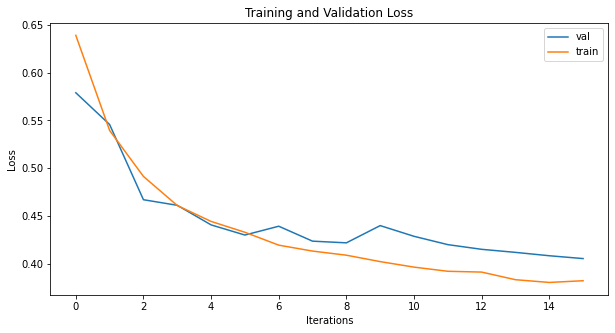

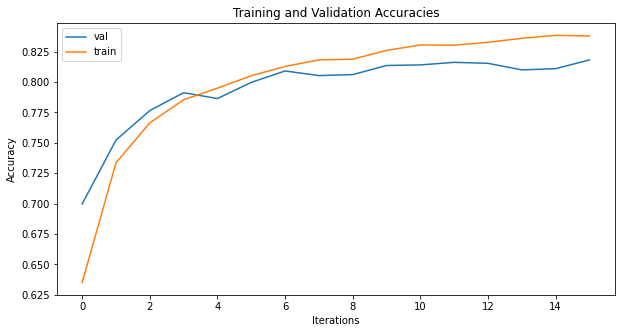

In [32]:
plot_losses(train_losses, val_losses)
plot_accuracies(accs, val_accs)

## <span style="color:teal">Make predictions</span>

In [33]:
def predict(review, vocab=word2ind, model=model):
    
    preprocessed = preprocess(review, 
                              lowercase=True, 
                              remove_punct=True, 
                              remove_stopwords=True)
    
    inputs = make_padded_inputs(preprocessed, vocab)
    pred_loader = torch.utils.data.DataLoader(torch.from_numpy(inputs), batch_size=1)
    
    model=model
    model.eval()
    
    for x in pred_loader:
        output = model(x)
    
    return "This review is positive" if output >= 0.5 else "This review is negative"

    
    
    

In [34]:
review = test_x_raw[871]
print(f"Review text: {review}", '\n', test_y[871])
predict(review)

Review text: "ZZZZZZZZZZZZZZZZZZ"! If IMDb would allow one-word reviews, that's what mine would be. This film was originally intended only for kids and it would seem to be very tough going for adults or older kids to watch the film. The singing, the story, everything is dull and washed out--just like this public domain print. Like other comedy team films with roots in traditional kids stories (such as the awful SNOW WHITE AND THE THREE STOOGES and the overrated BABES IN TOYLAND), this movie has limited appeal and just doesn't age well. Now that I think about it, I seriously doubt that many kids nowadays would even find this film enjoyable! So my advice is DON'T watch this film. If you MUST watch an Abbott and Costello film, almost any other one of their films (except for A&C GO TO MARS) would be an improvement. 
 0


'This review is negative'

In [35]:
review2 = test_x_raw[259]
print(review2, '\n', test_y[259])
predict(review2)

This film features two of my favorite guilty pleasures. Sure, the effects are laughable, the story confused, but just watching Hasselhoff in his Knight Rider days is always fun. I especially like the old hotel they used to shoot this in, it added to what little suspense was mustered. Give it a 3. 
 0


'This review is negative'

In [36]:
predict("The film was amazing.")

'This review is positive'

In [48]:
predict("I hated the film.")

'This review is negative'

## <span style="color:teal">Make the test set and test the model</span>

In [38]:
test_words = [preprocess(review, 
                      lowercase=True, 
                      remove_punct=True,
                      remove_stopwords=True
                     ) 
           for review in test_x_raw]

In [39]:
test_x = make_padded_inputs(test_words, word2ind)

In [40]:
print(test_x[10])

assert (len(test_words[10]) == np.count_nonzero(test_x[10])) or (64 == np.count_nonzero(test_x[10]))

[   2   27  146 1285 3537   25    2 1024   66   86    2   93  900 1629
 3546 3656    1   19  225  114  463  140   60   25    2  659  798   22
   73 2069    1    1    2  194  342  411    4  356 4720    1    1  191
  624    2  439 1025  376   24    9    2   13   39  976  325 3700  762
 2619    2  571  137   65   89 1338  169]


In [41]:
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [42]:
def test_accuracy(test_loader=test_loader,
                  model=model,
                  accuracy_f=accuracy
                 ):
    
    model=model
    total_acc = 0

    model.eval()
    for inputs, labels in test_loader:
        output = model(inputs)
        acc = accuracy(output, labels)
        total_acc += acc.item()
    
    return total_acc / len(test_loader)
        

In [49]:
test_acc = test_accuracy()
print(test_acc)

0.8194888178913738
